In [1]:
import cv2
import math
import data_process_ml

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url
import sklearn
from torch.utils.data import Subset
import pandas as pd
import copy

from sklearn.metrics import confusion_matrix
import seaborn as sns
import functions as fun

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split
from torchvision.datasets import VisionDataset
import os
from torch import optim
from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph
import pointnetfunct.data_process_ml

In [2]:

morpho_path = ".\AneuX\data-v1.0\data\morpho-per-cut.csv"
patient_path = ".\AneuX\data-v1.0\data\clinical.csv"
morpho_data_patient = data_process_ml.read_and_combine_data(morpho_path,patient_path)
merged_dataset = data_process_ml.encode_column(morpho_data_patient)
merged_dataset = data_process_ml.drop_columns(merged_dataset)
morpho_data_cut1,morpho_data_dome = data_process_ml.output_cut1anddome(merged_dataset)

d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(morpho_data_cut1.columns[3:23], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(['source_x',"cuttype","dataset"], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [3]:
# read data

class AneuxDataset_Morph(Dataset):

    def __init__(self, df, transform = None,test = False):

        self.transform = transform
        self.df = df.astype(float)
        self.label = df["status_ruptured"].copy()
        self.label = torch.from_numpy(np.array(self.label, dtype= int)) 
        self.raw_data = copy.deepcopy(self.df)
        self.raw_data.loc[self.raw_data['sex_male'] == 0, 'sex_male'] = 2
        #print(self.raw_data.iloc[0])
        self.raw_data.drop(("status_ruptured"),axis=1,inplace=True)
        self.raw_data.drop(("sex_female"),axis=1,inplace=True)
        self.raw_data['age'].fillna(self.raw_data['age'].mean(), inplace=True)
        #self.raw_data.drop(("age"),axis=1,inplace=True)
        if test == False:
            self.raw_data = self.raw_data[0:600]
        else:
            self.raw_data = self.raw_data[600:]
        self.my_device = "cuda:0"
    
    def __getitem__(self, index):
        
        """ Returns one data pair (image and target caption). """
        
        data = torch.from_numpy(np.array(self.raw_data.iloc[index],dtype = np.float64))
        label = self.label[index]
        #print(type(image))
        if self.transform is not None:      
            data= self.transform(data)
            
        return data,label

    def __len__(self):
                                
        return len(self.raw_data)

load data

In [4]:
#Morph_data = AneuxDataset_Morph(morpho_data_cut1,transform = None)

Morph_data = AneuxDataset_Morph(morpho_data_dome,transform = None)
Morph_data_test = AneuxDataset_Morph(morpho_data_dome,transform = None, test = True)

train_size = int(len(Morph_data) * 0.80) # 80% training data
valid_size = len(Morph_data) - train_size
train_data, valid_data = random_split(Morph_data, [train_size, valid_size])


train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=20,
    shuffle=True,
    #num_workers=2, 
    pin_memory=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=50, # Forward pass only so batch size can be larger
    shuffle=False,
    #num_workers=2, 
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    Morph_data_test,
    batch_size=50, # Forward pass only so batch size can be larger
    shuffle=False,
    #num_workers=2, 
    pin_memory=True
)

In [7]:
device = "cuda"
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    n = 0    # counter for number of minibatches
    with torch.no_grad():
        for data in loader:
            inputs_v, labels = data
            
            loss_fn = nn.CrossEntropyLoss()

            #to work with gpu you will need to load data and labels to gpu
            inputs_v = inputs_v.to(device)
            labels = labels.to(device)
            
            inputs_v = inputs_v.to(torch.float32)
            labels = labels.to(torch.long)

            outputs = net.forward(inputs_v)

            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1

            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels

    return running_loss/n, correct/total


# run model
def run_model_get(train_loader_input,vaild_loader_input,nepochs, modelnet,results_path, filename, transform = None,dataset =None):
    os.makedirs(results_path, exist_ok = True)
    saveCkpt = results_path + filename
    statsrec = np.zeros((4,nepochs))
    modelnet = modelnet.to(device)
    max_atst = 0
    mini_loss = 100
    for epoch in range(nepochs):  # loop over the dataset multiple times
        correct = 0          # number of examples predicted correctly (for accuracy)
        total = 0            # number of examples
        epoch_loss = 0.0   # accumulated loss (for mean loss)
        n = 0
        
        if transform != None:
            dataset.transform_image(transform)  
                        
        for data in train_loader_input:
            inputs, labels = data
            #print(inputs, labels)
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            #print(labels)
            modelnet.optimizer.zero_grad()
            # Forward, backward, and update parameters
            loss = modelnet.fit(inputs, labels) # note: .to(device) helps to load data to your gpu
            # accumulate loss
            epoch_loss += loss
            n += 1
            outputs = modelnet.forward(inputs)
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels

        # collect together statistics for this epoch
        ltrn = epoch_loss/n
        atrn = correct/total
        ltst, atst = stats(vaild_loader_input, modelnet)

        ltst = ltst.item() #item() moves the tensor data with 1 element to CPU

        statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
        print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")
        
        # if atst > max_atst:
        #     model_path = "DNN_dome_lr0.0001_epoch_test.pth"
        #     torch.save(modelnet.state_dict(), model_path)
        #     max_atst = atst
        if ltst < mini_loss:
            model_path = "DNN_dome_lr0.0001_epoch_test.pth"
            torch.save(modelnet.state_dict(), model_path)
            mini_loss = ltst

    # save network parameters, losses and accuracy
    torch.save({"state_dict": modelnet.state_dict(), "stats": statsrec}, saveCkpt)


# A simple DNN MODEL with 3 FCL

In [8]:
class DNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, output_size):
        super(DNNModel, self).__init__()

        # Define layers
        self.Flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.loss_fn = nn.CrossEntropyLoss(weight = torch.tensor([0.4,0.6]))
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(p=0.3)
        
        #Adam
        #self.optimizer = optim.Adam(self.parameters(), lr=0.001) #weight decay
        self.optimizer = optim.SGD(self.parameters(), lr=0.001)
        self.running_loss = 0
        self.loss = None
        self.losses = []

    def forward(self, x, target =None):
        # Forward pass
        #x = self.Flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x
    def fit(self, x, targets):
        #train/optimize/fit
        preds = self.forward(x)
        #print(preds, targets)
        self.loss = self.loss_fn(preds, targets.long())
        self.loss.backward()
        self.optimizer.step()
        
        loss_item = self.loss.item()
        return loss_item


    def reset_loss(self, value):
        self.running_loss = value
        self.losses = []
        return

In [9]:
DNN3Fcl = DNNModel(172,256,128,2)

run_model_get(train_loader_input = train_loader,
                        vaild_loader_input = valid_loader,
                        nepochs = 500, 
                        modelnet = DNN3Fcl,
                        results_path = "./result", 
                        filename = "/DNN_test.pt")

epoch: 0 training loss:  1.243 training accuracy:  66.2%  test loss:  0.665 test accuracy:  60.8%
epoch: 1 training loss:  1.074 training accuracy:  66.2%  test loss:  0.698 test accuracy:  70.8%
epoch: 2 training loss:  0.805 training accuracy:  67.5%  test loss:  0.976 test accuracy:  47.5%
epoch: 3 training loss:  0.836 training accuracy:  68.1%  test loss:  0.661 test accuracy:  59.2%
epoch: 4 training loss:  0.755 training accuracy:  70.2%  test loss:  0.854 test accuracy:  46.7%
epoch: 5 training loss:  0.683 training accuracy:  70.8%  test loss:  0.630 test accuracy:  67.5%
epoch: 6 training loss:  0.676 training accuracy:  71.0%  test loss:  0.629 test accuracy:  71.7%
epoch: 7 training loss:  0.699 training accuracy:  71.5%  test loss:  0.595 test accuracy:  71.7%
epoch: 8 training loss:  0.665 training accuracy:  72.7%  test loss:  0.650 test accuracy:  61.7%
epoch: 9 training loss:  0.649 training accuracy:  72.3%  test loss:  0.595 test accuracy:  68.3%
epoch: 10 training l

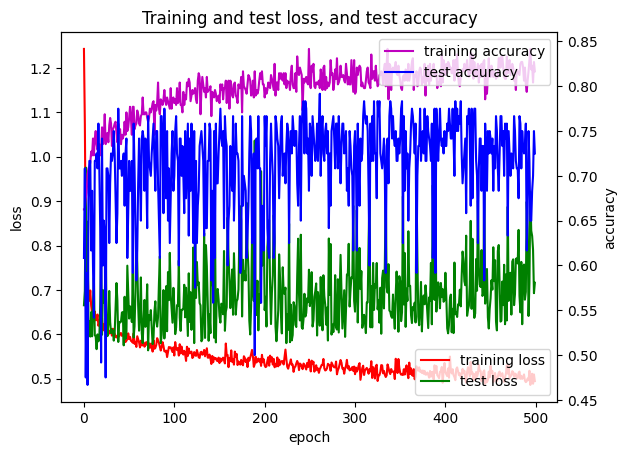

In [11]:
device = torch.device('cuda:0')
show_graph(path ="./result/DNN_test.pt",device = "cuda")

In [12]:



y_true = []
y_pred = []
y_pred_result = []
y_probs = []
pointnet_copy = DNN3Fcl.to("cpu")
with torch.no_grad():
    for inputs_v,labels in test_loader:
        inputs_v = inputs_v.to(torch.float32)
        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)



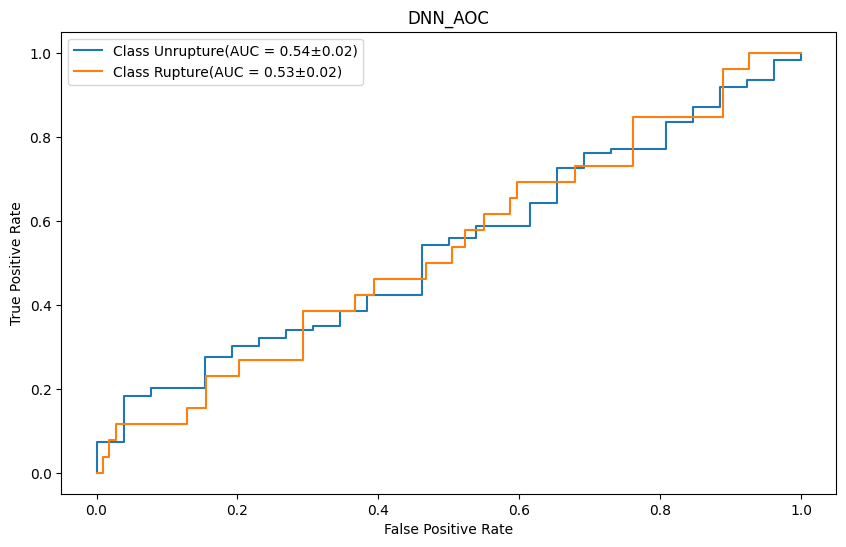

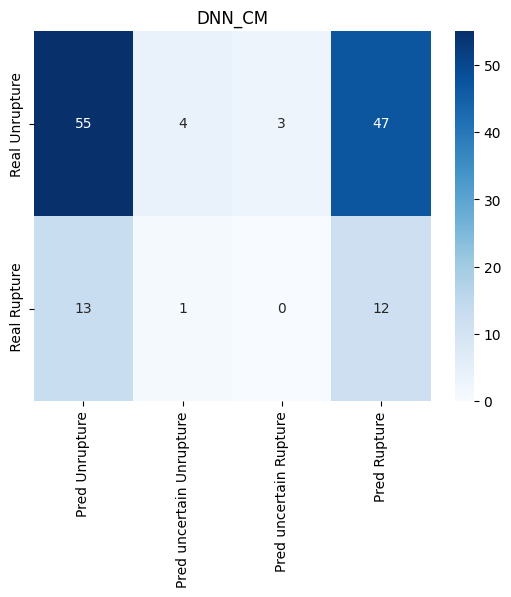

Accuracy: 0.5259259259259259
F1 score: 0.2727272727272727
Rupture Recall: 0.46153846153846156
Rupture Precision: 0.1935483870967742
UnRupture Recall: 0.5412844036697247
UnRupture Precision: 0.8082191780821918


In [13]:


draw_rocgraph(y_pred_result,y_true, y_probs, name="DNN_AOC")
show_cm_dl(y_true, y_pred,y_pred_result,name="DNN_CM")
print_values (y_true, y_pred_result)

In [14]:
y_true = []
y_pred = []
y_pred_result = []
y_probs = []
with torch.no_grad():
    for inputs_v,labels in valid_loader:
        inputs_v = inputs_v.to(torch.float32)
        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)

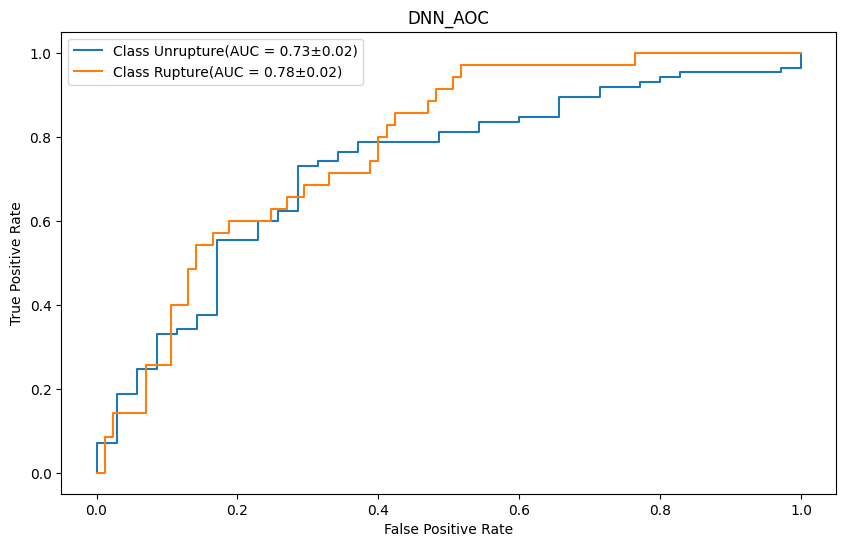

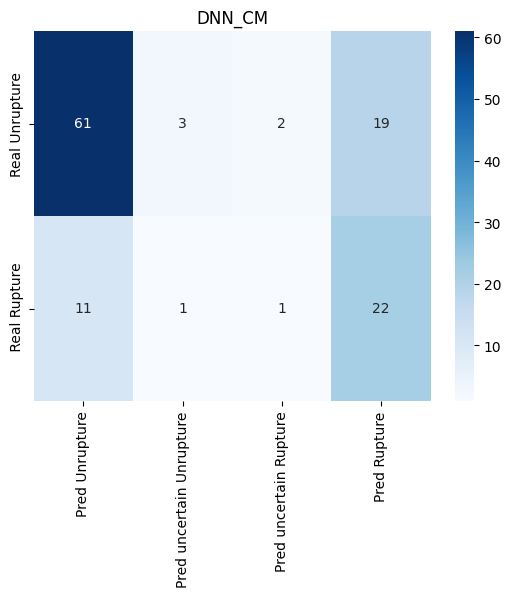

Accuracy: 0.725
F1 score: 0.5822784810126581
Rupture Recall: 0.6571428571428571
Rupture Precision: 0.5227272727272727
UnRupture Recall: 0.7529411764705882
UnRupture Precision: 0.8421052631578947


In [15]:
from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="DNN_AOC")
show_cm_dl(y_true, y_pred,y_pred_result,name="DNN_CM")
print_values (y_true, y_pred_result)

ascii: 71%+-3%